In [13]:
import pandas as pd
from datetime import datetime
import numpy as np
import pickle

# plotting
import matplotlib.pyplot as plt

# regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_pickle('Gas_Data/raw_joined_df.pkl')

In [16]:
df_target = df[['us_retail_wk_DPG']]
df_target = df_target.iloc[30:]
df_target.reset_index(inplace=True)
df_target.rename(columns={'index':'target_date', 'us_retail_wk_DPG':'target_price_DPG'}, inplace=True)

df_bs = df.reset_index()
df_bs.rename(columns={'index':'indicators_date'}, inplace=True)
# df_shifted = df_bs.merge(df_shift, left_index=True, right_index=True)
df_shift30 = pd.concat([df_bs, df_target], axis=1, join_axes=[df_bs.index])
# df_shifted.drop(df_shifted.columns[-3], axis=1, inplace=True)
df_shift30.head()

,indicators_date,us_retail_wk_DPG,wti_crudefuturesc1_DPG,wti_crudefuturesc3_DPG,nyh_HU_RBOBc1_DPG,nyh_HU_RBOBc3_DPG,wti_OKcrudespot_DPB,us_crudestock_TB,us_refyield_wk_pct,us_refcrudeinput_wk_TBD,...,US_PReserves_BB,Global_PReserves_BB,US_Imports_TBD,US_Exports_TBD,US_consumption_MTOE,Global_consumption_MTOE,US_refthru_TBD,Global_refthru_TBD,target_date,target_price_DPG
0,1993-01-15,1.066,18.87,19.17,0.540,0.584,18.89,1602955.0,47.5,13022.0,...,30.179001,1104.298906,8620.0,959.0,2036.658912,8311.393212,13613.0,60245.501447,1993-02-26,1.047
1,1993-01-18,1.061,18.87,19.12,0.539,0.583,18.94,1602955.0,47.5,13022.0,...,30.179001,1104.298906,8620.0,959.0,2036.658912,8311.393212,13613.0,60245.501447,1993-03-01,1.042
2,1993-01-19,1.061,18.58,18.83,0.530,0.575,18.40,1602955.0,47.5,13022.0,...,30.179001,1104.298906,8620.0,959.0,2036.658912,8311.393212,13613.0,60245.501447,1993-03-02,1.042
3,1993-01-20,1.061,18.33,18.68,0.523,0.570,18.35,1602955.0,47.5,13022.0,...,30.179001,1104.298906,8620.0,959.0,2036.658912,8311.393212,13613.0,60245.501447,1993-03-03,1.042
4,1993-01-21,1.061,18.81,19.07,0.529,0.573,18.71,1602955.0,47.5,13022.0,...,30.179001,1104.298906,8620.0,959.0,2036.658912,8311.393212,13613.0,60245.501447,1993-03-04,1.042


In [17]:
# Define X and y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

/Users/jas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


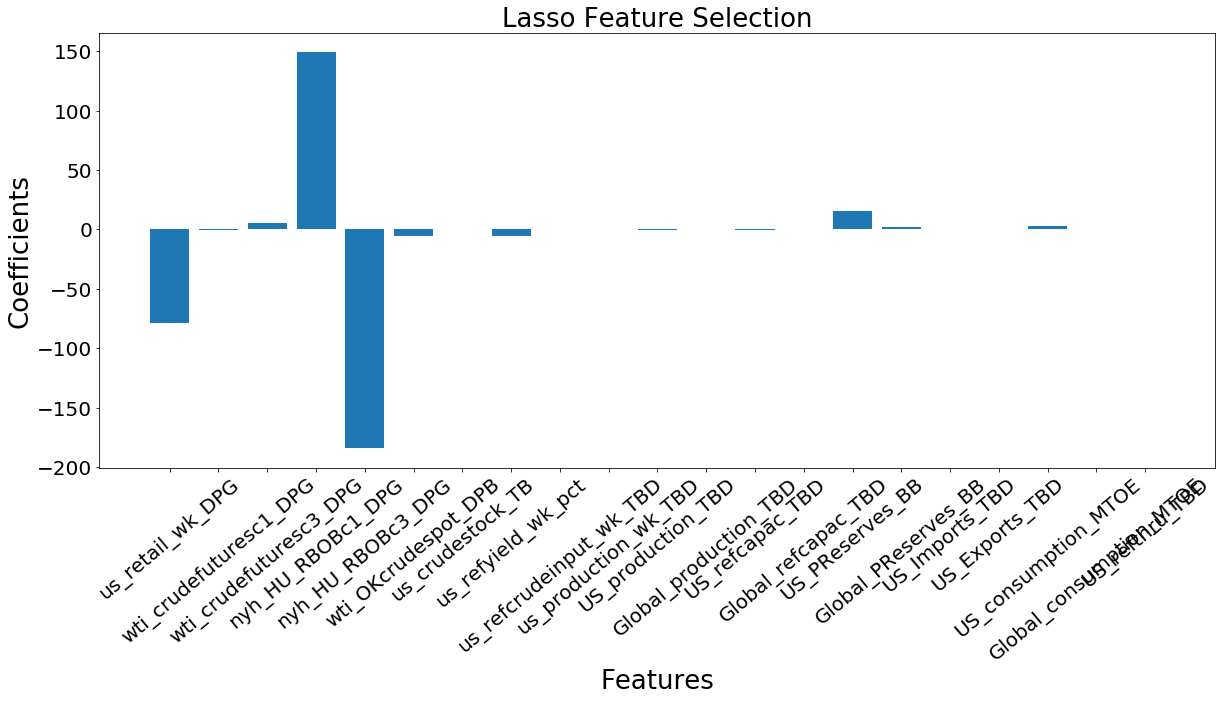

Score: 0.9991359398709756
MSE train: 32383.520608944338
MSE test: 32019.806305022277


In [22]:
# add polynomials into simplified (shift_r) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #tts
lasso = Lasso(alpha=1e-5, random_state=42)
lasso.fit(X_train, y_train)
lasso_coef = lasso.fit(X_train, y_train).coef_

plt.figure(figsize=(20,8))
plt.xticks(range(len(X.columns)), X.columns, rotation='40', fontsize='20')
plt.yticks(fontsize='20')
plt.ylabel('Coefficients', fontsize='26')
plt.xlabel('Features', fontsize='26')
plt.title('Lasso Feature Selection', fontsize='26')
plt.bar(range(len(X.columns)), lasso_coef)
#plt.savefig('Visuals/lasso_features2.png', cpi=300)
plt.show()


r2_adj = 1 - ((sum((y_test-lasso.predict(X_test)**2.0)/(len(X_test) - len(X.columns) - 1))
               /(sum((y_test - np.mean(y_test))**2.0)/(len(X_test) - 1))))

print('Score: {}'.format(lasso.score(X_test,y_test)))
print('MSE train: {}'.format(mean_squared_error(y_train, lasso.predict(X_train))))
print('MSE test: {}'.format(mean_squared_error(y_test, lasso.predict(X_test))))

In [21]:
r2_adj

146.1636689570248

# Autocorr

In [46]:
df_auto = df[['us_retail_wk_DPG']]

# weekly autocorr
df_auto = df_auto.resample(rule='W').last()
df_auto['change'] = df_auto.diff()
df_auto.dropna()
weekly_autocorr = df_auto['change'].autocorr()
print('Weekly autocorrelation: {}'.format(weekly_autocorr))

df_auto = df[['us_retail_wk_DPG']]
# Monthly autocorr
df_auto = df_auto.resample(rule='M').last()
df_auto['change'] = df_auto.diff()
df_auto.dropna()
monthly_autocorr = df_auto['change'].autocorr()
print('Monthly autocorrelation: {}'.format(monthly_autocorr))

df_auto = df[['us_retail_wk_DPG']]
# Annual autocorr
df_auto = df_auto.resample(rule='A').last()
df_auto['change'] = df_auto.diff()
df_auto.dropna()
annual_autocorr = df_auto['change'].autocorr()
print('Annual autocorrelation: {}'.format(annual_autocorr))

Weekly autocorrelation: 0.5034769163487682
Monthly autocorrelation: 0.3127482864564768
Annual autocorrelation: -0.2785083212895243
